# Predicting Speed Dating Success Using Various Personality Traits

## Introduction



Speed dating is an excellent method for determining someone's level of attraction and compatibility without wasting too much time. In a little period of time (approximately 3 to 8 minutes per person), it enables people to meet a large number of possible companions. Its main objective is to make it simpler for people to locate their ideal match.

In this study, we want to examine the factors that affect how likely it is that two people attending a speed dating event will click. We're interested in learning which qualities, such physical attractiveness, wit, and common interests, are most crucial for creating a connection between two people.
We're looking at data from a speed dating study that Columbia University researchers did between 2002 and 2004 to provide light on this subject.Over 500 people who participated in speed dating events are profiled in the dataset. These people responded to surveys about themselves and their partners before and after each encounter. Age, interests, hobbies, and other topics were covered. Participants also had the chance to say if they would like to see each of their speed dating partners again after the event (we will refer to this as a "match" for the remainder of this analysis). With the help of this data, we can assess the variables that affect the chances that two people will match. 



## Methods and Results

In this analysis, we will be using a K-Nearest Neighbours Classification model to determine whether an individual will match or not, based on traits like their attractiveness, funniness, and their shared interests with their partner. The point of this study is to determine whether there is a correlation between these traits and matching with a partner. 

#### 1. Importing Libraries

We begin by installing and importing the libraries required to properly read, analyze, and visualize the data.

In [1]:
# Install packages
# install.packages('tidyverse')
# install.packages('tidymodels')
# install.packages('themis')
# install.packages('repr')
# install.packages('gridExtra')
# install.packages('grid')
# install.packages('kknn')
# install.packages('GGally')

In [2]:
# Importing libraries
library(tidyverse)
library(tidymodels)
library(themis)
library(repr)
library(gridExtra)
library(grid)
library(GGally)
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.5     

Warning message:
“package ‘broom’ was built under R version 4.1.3”
Warni

#### 2. Reading the Data

[link]: http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/

Using the **read_csv()** function, we read the data from the [Teacher's College Columbia University database][link], and store it in a variable. We will then perform a short analysis on the data, getting information about the number of columns, rows, as well as a preview of what each observation looks like. 

In [3]:
# Reading the data
speed_dating_data <- read_csv("http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/Speed%20Dating%20Data.csv")

# Number of Rows and Columns
num_rows <- nrow(speed_dating_data)
num_cols <- ncol(speed_dating_data)

speed_dating_summary <- tibble(Rows = num_rows, 
                  Columns = num_cols)

# Previewing the data
speed_dating_preview <- head(speed_dating_data)

Rows: 8378 Columns: 195
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): field, undergra, from, career
dbl (187): iid, id, gender, idg, condtn, wave, round, position, positin1, or...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
speed_dating_summary

Rows,Columns
<int>,<int>
8378,195


> **Table 1.0: Number of Rows and Columns in the Dataset** <br />
> There are 8378 observations in the dataset, and 195 variables.

In [5]:
speed_dating_preview

iid,id,gender,idg,condtn,wave,round,position,positin1,order,⋯,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,1,1,1,10,7,NA,4,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,3,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,10,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,5,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,7,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,6,⋯,5,7,7,7,7,NA,NA,NA,NA,NA


> **Table 1.1: Head of the Dataset** <br />
> A preview of the speed dating dataset.

[link]: http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/Speed%20Dating%20Data%20Key.doc

From the speed dating dataset's [legend][link], we know there are many variables that are not useful in answering our research question, such as the individual's event ID, or the zipcode of where the individual was raised. There are many variables which do not use numerical values as well, such as the individual's career or field of study. Using 195 predictors would also be very computationally expensive, so we narrowed our possible predictors down to 6: attractiveness, sincerity, intelligence, funniness, ambition, and shared interest. We chose these variables because they can be numerically rated and are commonly discussed traits regarding relationships, and therefore would be ideal variables to use to predict whether an individual would match with their partner or not. In **Step 6**, we will further narrow down our predictors, by figuring out which variables have the highest correlation with whether or not the individual matches. 

#### 4. Tidying the Data

Our next step was to tidy the data into a state where we could easily use it to create our predictive model. We began by selecting the desired columns, and filtering out improper observations that could create future difficulties (N/A values, values that went by a different scale, etc.).

In [6]:
# Selecting desired rows
speed_dating_select <- speed_dating_data |>
    filter(wave != 6:9) |> # These waves had a different rating system for traits
    mutate(match = as_factor(match)) |>
    select(match, attr_o, sinc_o, intel_o, fun_o, amb_o, shar_o)

# Filtering the data of improper observations
speed_dating_tidy <- speed_dating_select |>
    filter(attr_o %% 1 == 0,
          sinc_o %% 1 == 0,
          intel_o %% 1 == 0,
          fun_o %% 1 == 0,
          amb_o %% 1 == 0, 
          shar_o %% 1 == 0,
          fun_o <= 10)

# Renaming categorical values
levels(speed_dating_tidy$match)[2] <- "yes"
levels(speed_dating_tidy$match)[1] <- "no"

# Renaming columns
colnames(speed_dating_tidy) <- c("Match", "Attractiveness", "Sincerity", "Intelligence", "Funniness", "Ambition", "Shared_Interest")

# Preview of tidied dataset
head(speed_dating_tidy)

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `wave != 6:9`.
Caused by warning in `wave != 6:9`:
! longer object length is not a multiple of shorter object length”


Match,Attractiveness,Sincerity,Intelligence,Funniness,Ambition,Shared_Interest
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,6,8,8,8,8,6
no,7,8,10,7,7,5
yes,10,10,10,10,10,10
yes,7,8,9,8,9,8
yes,8,7,9,6,9,7
no,7,7,8,8,7,7


> **Table 2.0: Tidied Dataset** <br />
> The head of the tidied dataset that we will be working with for the remainder of this study. <br />
> **IMPORTANT NOTE**: 10 is the highest or "best" value, while 0 is the lowest or "worst" value. 

#### 5. Column Legend
- **Match**: Whether or not the individual matched with their partner
- **Attractiveness**: How attractive the individual was rated by their partner
- **Sincerity**: How sincere the individual was rated by their partner
- **Intelligence**: How intelligent the individual was rated by their partner
- **Funniness**: How funny the individual was rated by their partner
- **Ambition**: How ambitious the individual was rated by their partner
- **Shared_Interest**: How similar the individual and partner's interests are

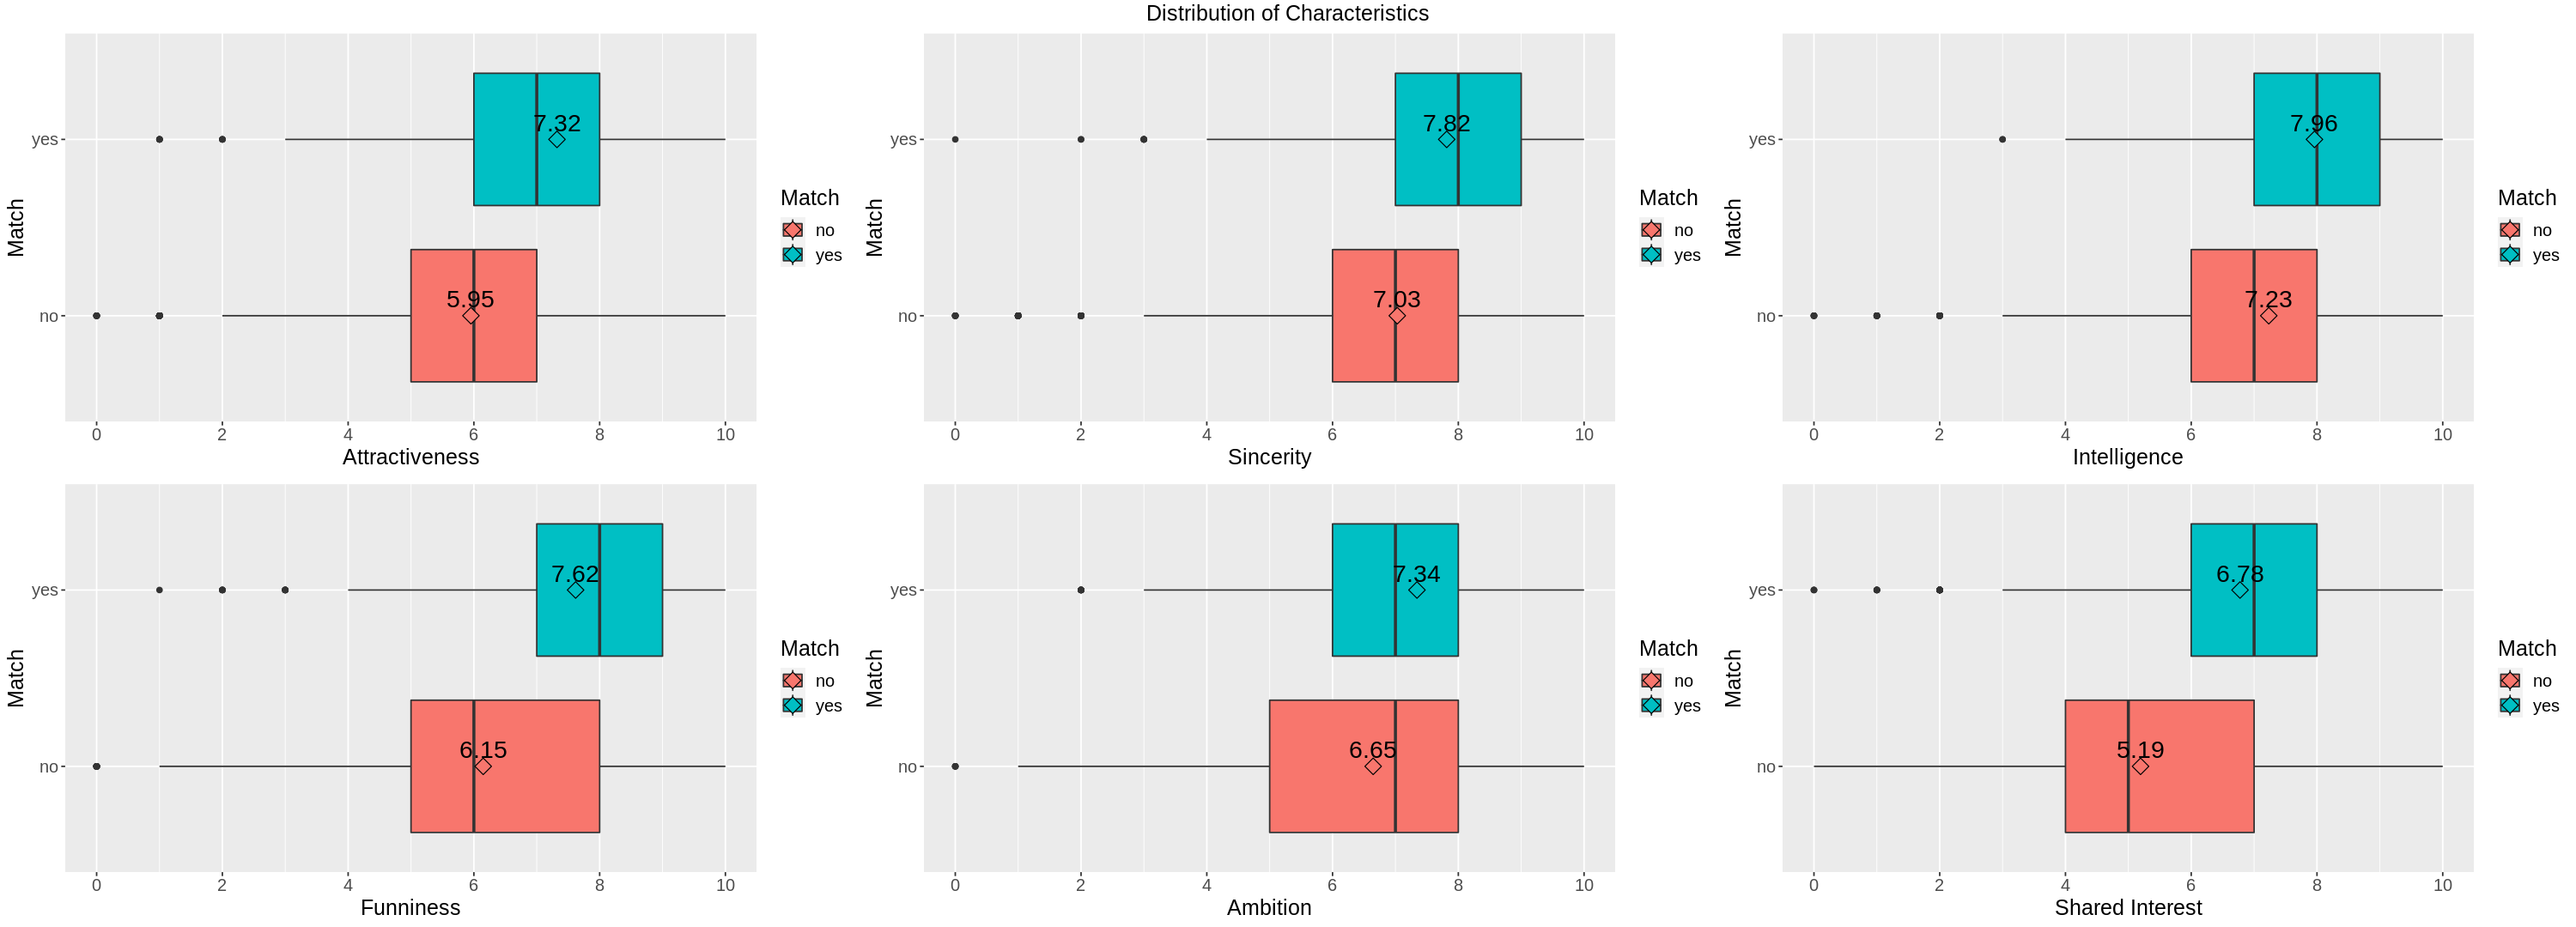

In [7]:
# Plotting
options(repr.plot.width=25, repr.plot.height=9)

attract_boxplot <- speed_dating_tidy |>
    ggplot(aes(x = Attractiveness, y = Match, fill = Match)) + 
    geom_boxplot() +
    labs(x = "Attractiveness", y = "Match", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

sincere_boxplot <- speed_dating_tidy |>
    ggplot(aes(x = Sincerity, y = Match, fill = Match)) + 
    geom_boxplot() +
    labs(x = "Sincerity", y = "Match", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

intel_boxplot <- speed_dating_tidy |>
    ggplot(aes(x = Intelligence, y = Match, fill = Match)) + 
    geom_boxplot() +
    labs(x = "Intelligence", y = "Match", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

funny_boxplot <- speed_dating_tidy |>
    ggplot(aes(x = Funniness, y = Match, fill = Match)) + 
    geom_boxplot() +
    labs(x = "Funniness", y = "Match", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

ambition_boxplot <- speed_dating_tidy |>
    ggplot(aes(x = Ambition, y = Match, fill = Match)) + 
    geom_boxplot() +
    labs(x = "Ambition", y = "Match", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

shared_interest_plot <- speed_dating_tidy |>
    ggplot(aes(x = Shared_Interest, y = Match, fill = Match)) + 
    geom_boxplot() +
    labs(x = "Shared Interest", y = "Match", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

grid.arrange(attract_boxplot, sincere_boxplot, intel_boxplot, funny_boxplot, ambition_boxplot, shared_interest_plot,
             nrow = 2, top = textGrob("Distribution of Characteristics", gp=gpar(fontsize=15,font=8)))

> **Figure 1.0: Distributions of Characteristics** <br />
> A distribution of all of the observation's physical and personality traits. 

#### 6. Variable Importance

By looking at the figure above, we can see that some variables clearly have a higher correlation with being matched than others. For example, the median funniness rating of those who matched was 8, while those who did not match had a median of 6, so clearly being more funny increases your chances of being matched. However, the median score for ambition of both those who matched and those who did not are both 7, implying that ambition has a weaker correlation with being matched. To get a better understanding of these relationships, we will take the difference of means of each trait between the groups who matched and the groups who didn't, and see which values have the largest difference, and therefore the strongest correlation with being matched.

In [8]:
# Taking means of each trait
speed_dating_means <- speed_dating_tidy |>
    group_by(Match) |>
    summarize(Mean_Attractiveness = mean(Attractiveness),
              Mean_Sincerity = mean(Sincerity),
              Mean_Intelligence = mean(Intelligence),
              Mean_Funniness = mean(Funniness),
              Mean_Ambition = mean(Ambition), 
              Mean_Shared_Interest = mean(Shared_Interest))
speed_dating_means

Match,Mean_Attractiveness,Mean_Sincerity,Mean_Intelligence,Mean_Funniness,Mean_Ambition,Mean_Shared_Interest
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,5.953032,7.029332,7.233399,6.148101,6.645852,5.193990
yes,7.321429,7.815331,7.959930,7.617596,7.342334,6.776132


> **Table 3.0: Means of "Yes" and "No" Traits** <br />
> Note that the means of the "yes" observations are all higher than the "no" observations, implying some correlation between the traits and whether an observation matches or not.

Now that we have the means, we will take the difference between the observations that matched and the ones that did not, to see which has the largest correlation. 

In [9]:
# Means of observations that matched
speed_dating_yes <- speed_dating_means |>
    slice(1) |>
    select(-Match) 

# Means of observations that did not match
speed_dating_no <- speed_dating_means |>
    slice(2) |>
    select(-Match)

# Taking the difference of "yes" and "no" means
speed_dating_diffs <- abs(speed_dating_yes - speed_dating_no)

# Renaming columns
colnames(speed_dating_diffs) <- c("Attract_Diff", "Sincere_Diff", "Intel_Diff", "Funny_Diff", "Ambition_Diff", "Shared_Interest_Diff")

speed_dating_diffs

Attract_Diff,Sincere_Diff,Intel_Diff,Funny_Diff,Ambition_Diff,Shared_Interest_Diff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.368396,0.7859986,0.726531,1.469494,0.6964824,1.582143


> **Table 3.1: Class Trait Mean Differences** <br />
> Since the differences are larger in Attractiveness, Funniness, and Shared Interest, we can say that they have a stronger correlation with being matched.

#### 7. Variable Discussion

From the table above, we observe that **attractiveness**, **funniness** and **shared interest** have a significantly stronger correlation with getting a match than the other traits. Therefore, we will create a model which only uses those 3 variables as predictors, as it will create a more accurate model.

#### 8. Creating the Classification Model

Now that we have concluded our exploratory data analysis, we can create our predictive model, using the predictors that we selected.
We will be creating a **K-Nearest Neighbours** classification model to predict whether an observation will match or not. To begin, we will split the data into a training set and a testing set, with proportions of **75%** and **25%**, respectfully. 

In [10]:
# Setting a seed
set.seed(1000)

# Splitting the data
speed_dating_split <- initial_split(speed_dating_tidy, prop = 0.75, strata = Match)
speed_dating_train <- training(speed_dating_split)
speed_dating_test <- testing(speed_dating_split)

#### 9. Upsampling the Data

One issue with our dataset that was noticed is that there exists a class imbalance between the observations who matched and the ones who did not (see table below). Since we plan to use a K-Nearest Neighbours classifier, a class imbalance is quite problematic, as most of the neighbours will be ones that did not match, so the model will classify almost every observation as one that did not match. To fix this, we will upsample the minority class in the training class, so the model is trained with a balanced dataset.

In [11]:
# Identifying class imbalance
speed_dating_train |>
    group_by(Match) |>
    summarize(n = n())

Match,n
<fct>,<int>
no,4167
yes,861


> **Table 4.0: Class Counts in the Training Set** <br />
> There are significantly more "no" observations, which indicates a class imbalance.

In [12]:
# Prepping the recipe
upsample_recipe <- recipe(Match ~ Attractiveness + Funniness + Shared_Interest, data = speed_dating_train) |>
  step_upsample(Match, over_ratio = 1, skip = FALSE) |>
  prep()

# Baking a new training set
speed_dating_train_upsampled <- bake(upsample_recipe, speed_dating_train)

# Matches
speed_dating_train_upsampled |>
    group_by(Match) |>
    summarize(n = n())

Match,n
<fct>,<int>
no,4167
yes,4167


> **Table 4.1: Class Counts in the Upsampled Training Set** <br />
> Now that the training set is no longer unbalanced, the model will take more "yes" observations into account, and we avoid bias towards "no" observations. 

#### 10. Tuning the Model

Now that we have upsampled the training data, we can perform a **5 fold Cross Validation** on the training data, to find the optimal value of **K** to use in our model.

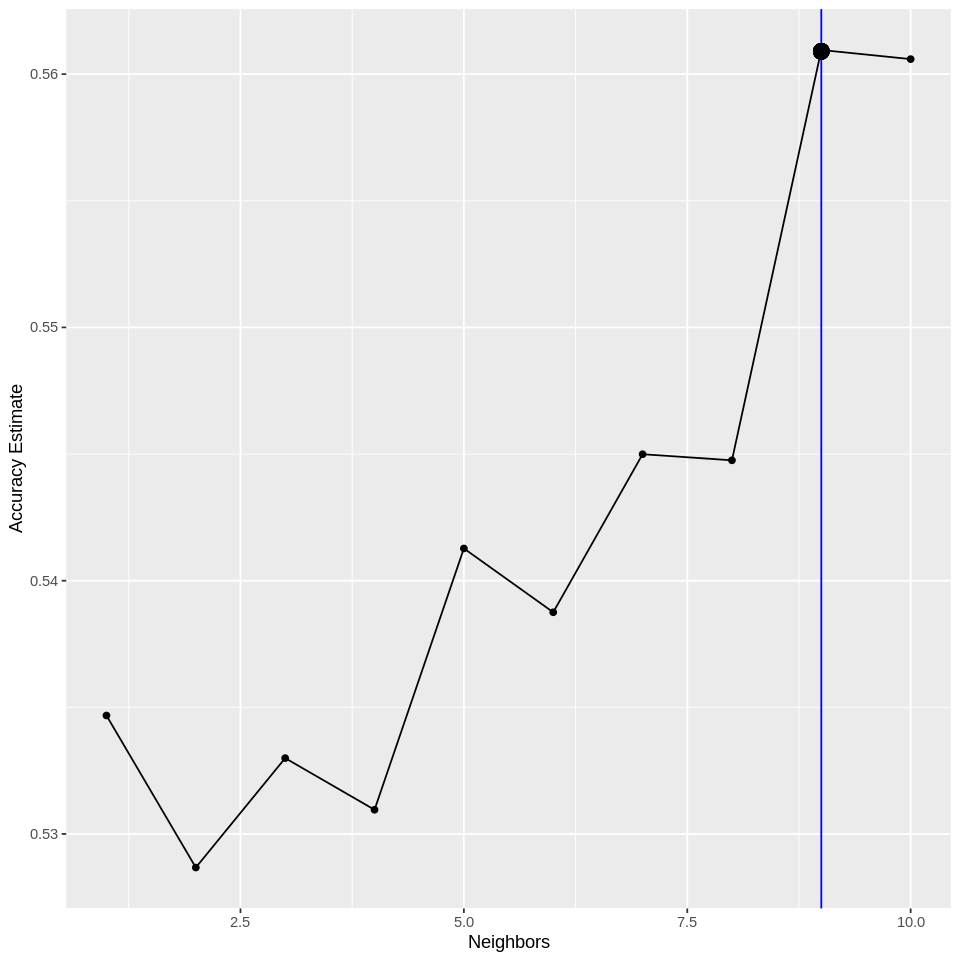

In [13]:
options(repr.plot.width=8, repr.plot.height=8)

# Setting a seed
set.seed(1000)

# Creating a tuning model
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Creating the folds
speed_dating_vfold <- vfold_cv(data = speed_dating_train_upsampled, v = 5, strata = Match)

# K values that we would like to test
k_value <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# Creating an upsampled recipe
# Note: no need to scale, as all variables are rated from 0-10
speed_dating_recipe <- recipe(Match ~ Attractiveness + Funniness + Shared_Interest, data = speed_dating_train_upsampled)

# Performing the cross validation, and collecting the results
knn_results <- workflow() |>
    add_recipe(speed_dating_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = speed_dating_vfold, grid = k_value) |>
    collect_metrics() 

accuracies <- knn_results |>
    filter(.metric == "accuracy")

# Plotting the results
cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 9, colour = "blue") +
    geom_point(aes(x = 9, y = 0.5609), size = 4) +
    labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot

> **Figure 2.0: Cross-Validation Results** <br />
> A plot of the validation accuracy of each k value used on the training set. The maximum value is 9.

#### 11. Creating the Model

By observing the plot above and seeing which K value will result in the highest accuracy, we decided to create a K-NN Classification model which uses **9** neighbours. 

In [14]:
# Creating a model with the optimal K value
knn_optimal <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

# Fitting the model on the training data
speed_dating_fit <- workflow() |>
    add_recipe(speed_dating_recipe) |>
    add_model(knn_optimal) |>
    fit(data = speed_dating_train_upsampled)

#### 12. Testing the model

Now that we have created a model, we will apply it to the **testing set** to analyze the accuracy of this model.

In [15]:
# Predicting the classes of the testing set using the model we fit earlier
predictions <- predict(speed_dating_fit, speed_dating_test) |>
    bind_cols(speed_dating_test)

# Collecting the metrics of the predictions
accuracies <- predictions |>
    metrics(truth = Match, estimate = .pred_class)

accuracies

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8163387
kap,binary,0.1381633


> **Table 5.0: Model Prediction Accuracy** <br />
> The model resulted in 82% accuracy when tested on the testing set.

The results of our model show that it has around an **82%** accuracy when applied to the testing set. We will create a plot of the **confusion matrix** to get a better understanding of which parts of our model could be improved.

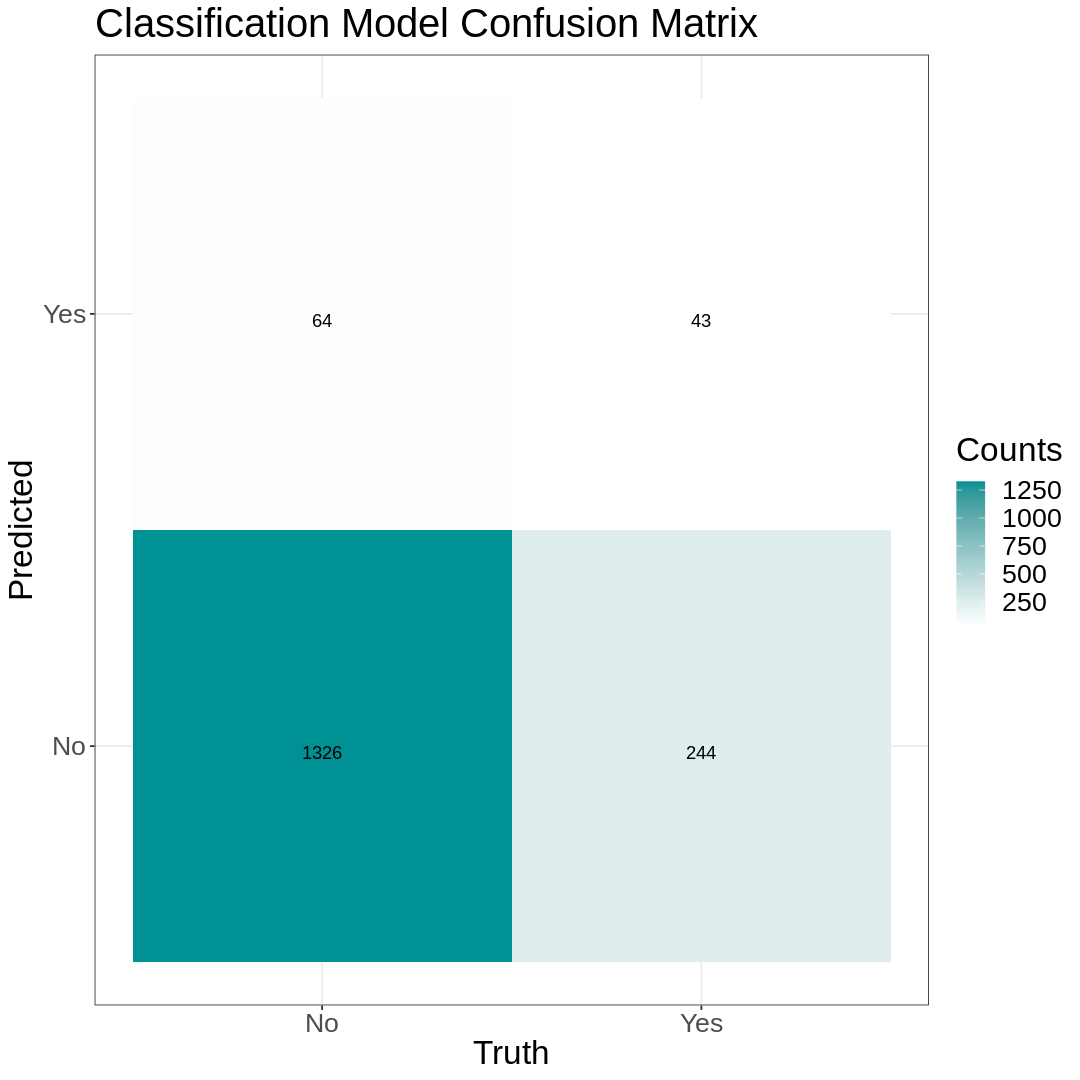

In [16]:
options(repr.plot.width=9, repr.plot.height=9)

# Creating a confusion matrix of our predictions
accuracy_matrix <- predictions |>
    conf_mat(truth = Match, estimate = .pred_class)

# Making a table from the confusion matrix
true_class <- factor(c("Yes", "Yes", "No", "No"))
predicted_class <- factor(c("Yes", "No", "Yes", "No"))
counts <- c(43, 244, 64, 1326) # Values found by observing result of using conf_mat on the predictions

matrix_table <- tibble(Truth = true_class,
                       Predicted = predicted_class,
                       Counts = counts)

# Plotting the confusion matrix
matrix_table |> ggplot(aes(x = Truth, y = Predicted, fill = Counts)) +
    geom_tile() +
    geom_text(aes(label = Counts), vjust = 1) +
    scale_fill_gradient(low = "white", high = "#009194") +
    theme_bw() + 
    theme(text = element_text(size = 20)) + 
    ggtitle("Classification Model Confusion Matrix")

> **Figure 3.0: Prediction Confusion Matrix** <br />
> The majority of the predictions were "no" predictions, and there were very few correctly predicted "yes" observations. 

#### 13. Results

From the plot above, we can see that this model has **very few true positives**, which implies that it is actually not very effective for predicting whether an individual will match based on their attractiveness, funniness, and shared interests with their partner. The reason the accuracy remains high is due to most of the observations in the testing set not matching, so our model, which almost always predicts that an observation will not match, is still usually correct. In the next section, we discuss the importance of these findings and future research questions that this will lead to. 

## Discussion

#### Our Findings

Despite the inaccuracies of our model, there is still much to learn from the results. Our model correctly predicted most of the observations that did not match, which implies that having lower ratings of your characteristics (attractiveness, funniness, etc.) correlates with *not* matching. However, this also implies that this correlation is not present in higher ratings, as our model failed to predict many observations that did match. This is reasonable as the means of the observations that matched were higher than the ones that didn't (see Table 3.0: Means of "Yes" and "No" Traits), but were not exceptionally high, hovering around 7-8 at average. 

#### Expectations and Results

Our original expectation was that these characteristics would have an extremely strong correlation with matching, since it makes sense that the more attractive or funny you are, the most desirable you are for future dates, or a longer term relationship. However, we see from the outliers of the observations that matched (see Figure 1.0: Distributions of Characteristics) that this is not always true, as some people that matched were rated as low as 1 in attractiveness, or even 0 in shared interest, still matched. These outliers are also reasonable, implying that many characteristics are taken into account when deciding whether someone is a good match for you, not just how attractive or funny they are. 

An important aspect that must be taken into account with this study is the subjectiveness of these traits. A detail that was not covered in this study was that the same individual was often rated differently by different participants, so using these traits as a predictor can be very inaccurate, as different people's perception of what is or isn't attractive can vary drastically. It is also important to realize that the data from this study was taken from a speed dating event, so it may be even more inaccurate if applied to relationship activities outside of speed dating. 

#### The Importance of this Study

This study can be useful for future researchers who are working with relationship related studies, as they can use the model to predict whether individuals have a high chance of matching or not. It is also useful for researchers studying the nature of human relationships, and what actually makes an individual want an relationship with another. It also reveals a bit about the nature behind human attraction, seeing as having better traits like attractiveness or intelligence does not always make an individual more desirable for a relationship. 

#### Future Questions

Human relationships are an incredibly complex topic to cover, and this study only investigates a small portion of the nuances behind relationships. Many aspects of this study could be improved, and these are useful questions that could be expanded on in future studies. For example, researchers may want to explore the correlation between other traits, such as income, gender, and age with matching. This would allow for an even better understanding of what people are searching for during a speed dating session, and perhaps a more accurate prediction model for whether an individual matches or not. Studies can also be conducted on the correlation between different traits, such as investigating whether one's funniness correlates with their attractiveness. 

#### Conclusion

There are endless opportunities to explore when it comes to human relationships, and studies of simple characteristics like the ones in the analysis above are simply an elementary exploration of what these relationships have underneath. As of now, there are still thousands of studies conducted every day, trying to deconstruct and analyze the human mind, and we may never truly fully understand what causes human attraction, but every study gives us a bit better of an understanding, and by doing so, revolutionary ideas and inventions will naturally emerge and improve our society as a whole.

## References

Gelman, A., & Hill, J. Speed Dating. Index of /gelman/arm/examples/speed.dating. Retrieved from http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/ 

Graff, M. (2022). Improving your chances in speed dating. Psychology Today. Retrieved from https://www.psychologytoday.com/us/blog/love-digitally/202211/improving-your-chances-in-speed-dating 

McNulty, K. (2020, February 14). What matters in speed dating? Medium. Retrieved from https://towardsdatascience.com/what-matters-in-speed-dating-34d29102f6cb 

UCLA, D. R. at. (2020, June 5). Secrets to maximizing success in the (speed) dating experience. Medium. Retrieved from https://ucladatares.medium.com/secrets-to-maximizing-success-in-the-speed-dating-experience-7f4f50c40019 